In [1]:
import os
import ast
import re
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import constants

# Summarize baseline results into Pandas DataFrame

In [2]:
def summarize(path, fname):
    model_meta = pd.read_parquet(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['train_loss', 'train_acc', 'valid_loss', 'valid_acc']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_loss'].apply(len)
    model_meta['final_train_loss'] = model_meta['train_loss'].apply(lambda x: x[-1])
    model_meta['final_valid_acc'] = model_meta['valid_acc'].apply(lambda x: x[-1])
    model_meta['final_valid_loss'] = model_meta['valid_loss'].apply(lambda x: x[-1])
    model_meta['best_valid_loss'] = model_meta['valid_loss'].apply(min)

    return model_meta

In [3]:
model_meta = pd.DataFrame()

root_dir = os.path.join(constants.FINE_TUNING_RESULTS_DIR,
                        'film',
                        'fixed_batch_size',
                        'film_layer4_bn3')
base_dir = root_dir
source_train_baseline_dir = os.path.join(base_dir, 'film_s_20k_t_20')
exp_dir = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]


for f in os.listdir(source_train_baseline_dir):
    if f.endswith('.parquet') and f.startswith('source'):
        trial_results = summarize(os.path.join(root_dir, source_train_baseline_dir), f)
        phase, _, iter_idx, _ = re.split('[_.]', f)
        trial_results.loc[:, 'phase'] = phase
        trial_results.loc[:, 'iter_idx'] = iter_idx

        try:
            with open(os.path.join(root_dir, source_train_baseline_dir, f'args_{iter_idx}.json')) as arg_f:
                args = json.load(arg_f)
        except OSError:
            print('No corresponding args.json file associated with trial!')

        for key in ['num_source_epochs', 'num_target_epochs', 'source_lr', 'target_lr', 'source_batch_size', 'target_batch_size',
                    'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
            trial_results.loc[:, key] = args[key]

        model_meta  = model_meta.append(trial_results, ignore_index=True)
    
for d in exp_dir:
    for f in os.listdir(os.path.join(root_dir, d)):
        if (f.endswith('.parquet')) and ('target' in f):
            trial_results = summarize(os.path.join(root_dir, d), f)
            phase, _, iter_idx, _ = re.split('[_.]', f)
            trial_results.loc[:, 'phase'] = phase
            trial_results.loc[:, 'iter_idx'] = iter_idx

            try:
                with open(os.path.join(root_dir, d, f'args_{iter_idx}.json')) as arg_f:
                    args = json.load(arg_f)
            except OSError:
                print('No corresponding args.json file associated with trial!')

            for key in ['num_source_epochs', 'num_target_epochs', 'source_lr', 'target_lr', 'source_batch_size', 'target_batch_size',
                        'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
                trial_results.loc[:, key] = args[key]

            model_meta = model_meta.append(trial_results, ignore_index=True)
        

# Summarize performance for trained models

In [4]:
source_meta = model_meta[model_meta['phase'] == 'source']

performance_cols = ['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc',
                    'chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc']

In [5]:
source_meta.mean()[performance_cols]

mimic_test_loss       0.605534
mimic_test_acc        0.777012
mimic_test_auc        0.829625
chexpert_test_loss    0.567824
chexpert_test_acc     0.859333
chexpert_test_auc     0.905012
dtype: float64

In [6]:
target_meta = model_meta[model_meta['phase'] == 'target']

performance_cols = ['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc',
                    'chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc']

In [7]:
target_meta.groupby('n_target_samples').max(numeric_only=True)[performance_cols]

,mimic_test_loss,mimic_test_acc,mimic_test_auc,chexpert_test_loss,chexpert_test_acc,chexpert_test_auc
n_target_samples,,,,,,
20,0.614619,0.777137,0.835160,0.579853,0.841625,0.902596
50,0.616179,0.776134,0.828783,0.586625,0.841000,0.903435
100,0.615591,0.769742,0.827440,0.589687,0.818500,0.896988
200,0.616051,0.772875,0.831025,0.587957,0.818625,0.896373
500,0.618649,0.772249,0.829526,0.588807,0.819625,0.897193
1000,0.618379,0.776510,0.831371,0.588292,0.823500,0.897229


In [8]:
target_meta.groupby('n_target_samples').mean()[performance_cols]

,mimic_test_loss,mimic_test_acc,mimic_test_auc,chexpert_test_loss,chexpert_test_acc,chexpert_test_auc
n_target_samples,,,,,,
20,0.609119,0.773043,0.830845,0.576432,0.822542,0.895771
50,0.610501,0.773335,0.826895,0.577194,0.819417,0.890370
100,0.611235,0.767903,0.824113,0.582181,0.800917,0.886989
200,0.611909,0.770452,0.826390,0.580944,0.805500,0.886955
500,0.612499,0.769408,0.825737,0.581118,0.805583,0.886230
1000,0.612955,0.772416,0.826997,0.580623,0.807083,0.886437


In [9]:
target_meta.groupby('n_target_samples').std()[performance_cols]

,mimic_test_loss,mimic_test_acc,mimic_test_auc,chexpert_test_loss,chexpert_test_acc,chexpert_test_auc
n_target_samples,,,,,,
20,0.004766,0.006663,0.003793,0.003901,0.016544,0.006228
50,0.004919,0.003443,0.001967,0.008422,0.029735,0.011603
100,0.003773,0.001636,0.003365,0.006511,0.022270,0.008676
200,0.003596,0.002099,0.005046,0.006201,0.020920,0.008259
500,0.005336,0.002707,0.004967,0.006821,0.022928,0.009501
1000,0.004699,0.004137,0.005650,0.006988,0.022354,0.009399


In [10]:
mimic_meta = target_meta.melt(id_vars=['n_target_samples'], value_vars=['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc'])
chex_meta = target_meta.melt(id_vars=['n_target_samples'], value_vars=['chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc'])

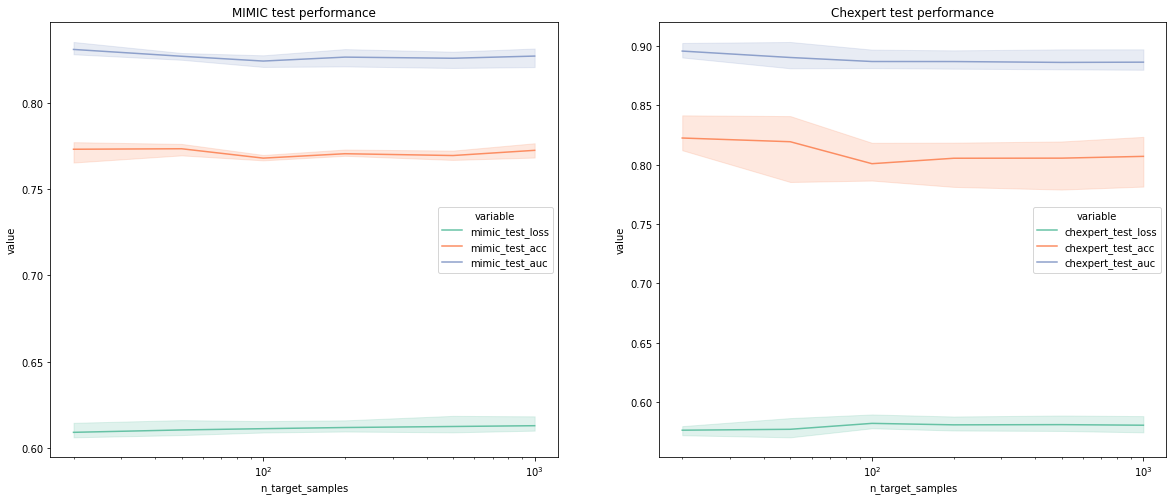

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(data=mimic_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[0])
ax[0].set_title('MIMIC test performance')
ax[0].set(xscale='log')
sns.lineplot(data=chex_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[1])
ax[1].set_title('Chexpert test performance')
ax[1].set(xscale='log');

# Visualize training and validation losses for the two training phases

In [12]:
def plot_losses(df, phase='target', n_target_samples=20, loss_type='train', ax=None):
   
    if phase == 'target':
        df = df[df['n_target_samples'] == n_target_samples].copy()
    subset_df = df[df['phase'] == phase].copy()
    key = f'{loss_type}_loss'
    max_len = max([len(ele) for ele in subset_df.loc[:, key].values])
    stackable = [np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan) for arr in subset_df.loc[:, key].values]
    losses = np.stack(stackable)

    avg_loss = np.mean(losses, axis=0)
    upper_ = avg_loss + np.std(losses, axis=0)
    lower_ = avg_loss - np.std(losses, axis=0)
    x_ = np.arange(len(upper_))

    ax.fill_between(x_, lower_, upper_, color='k', alpha=0.1)
    ax.plot(avg_loss, 'k--')
    ax.plot(losses.T)
    ax.legend(['average loss', 'iter 0', 'iter 1', 'iter 2', '+/- std'], loc='upper right')

    ax.set_title(f'{loss_type} loss on the {phase} domain'.title())
    ax.set_xlabel('epochs')
    ax.set_ylabel('BCE loss')


## 20 MIMIC samples

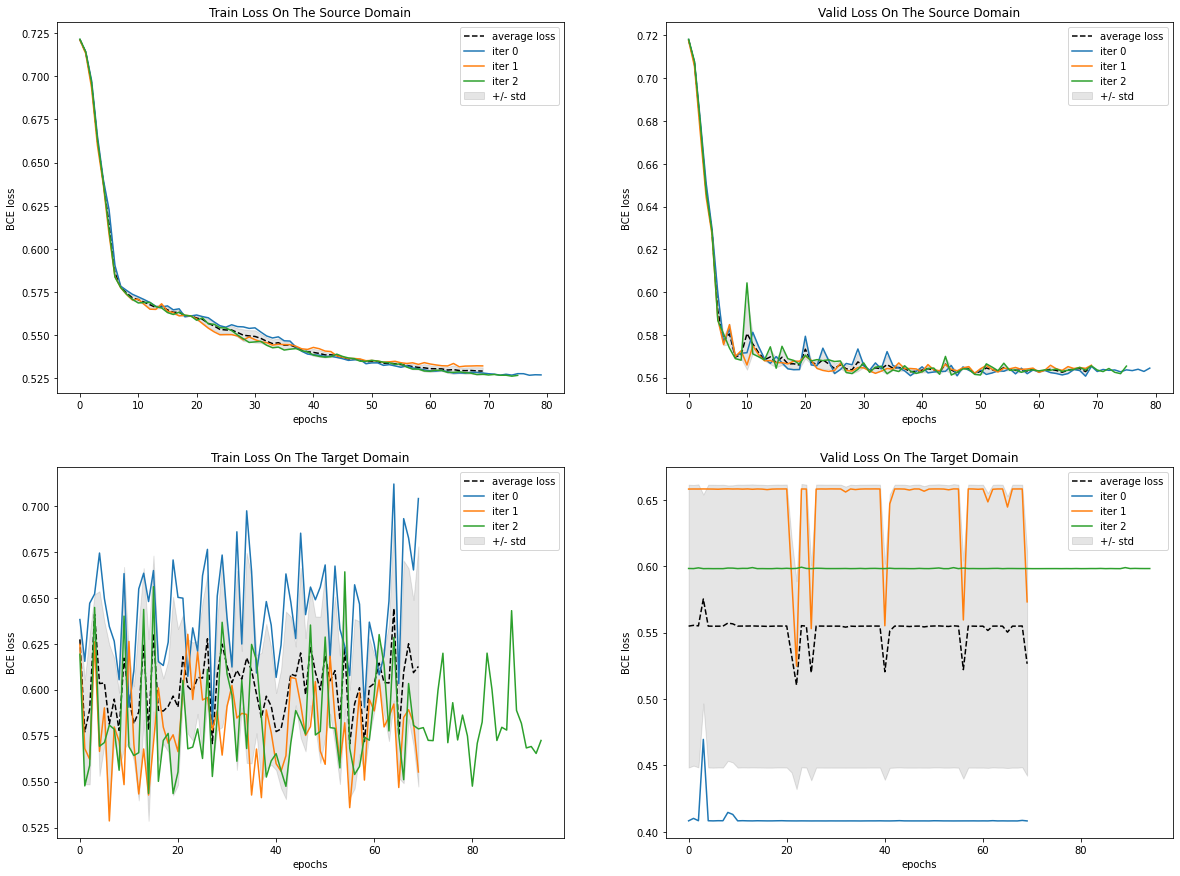

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 20

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 50 MIMIC samples

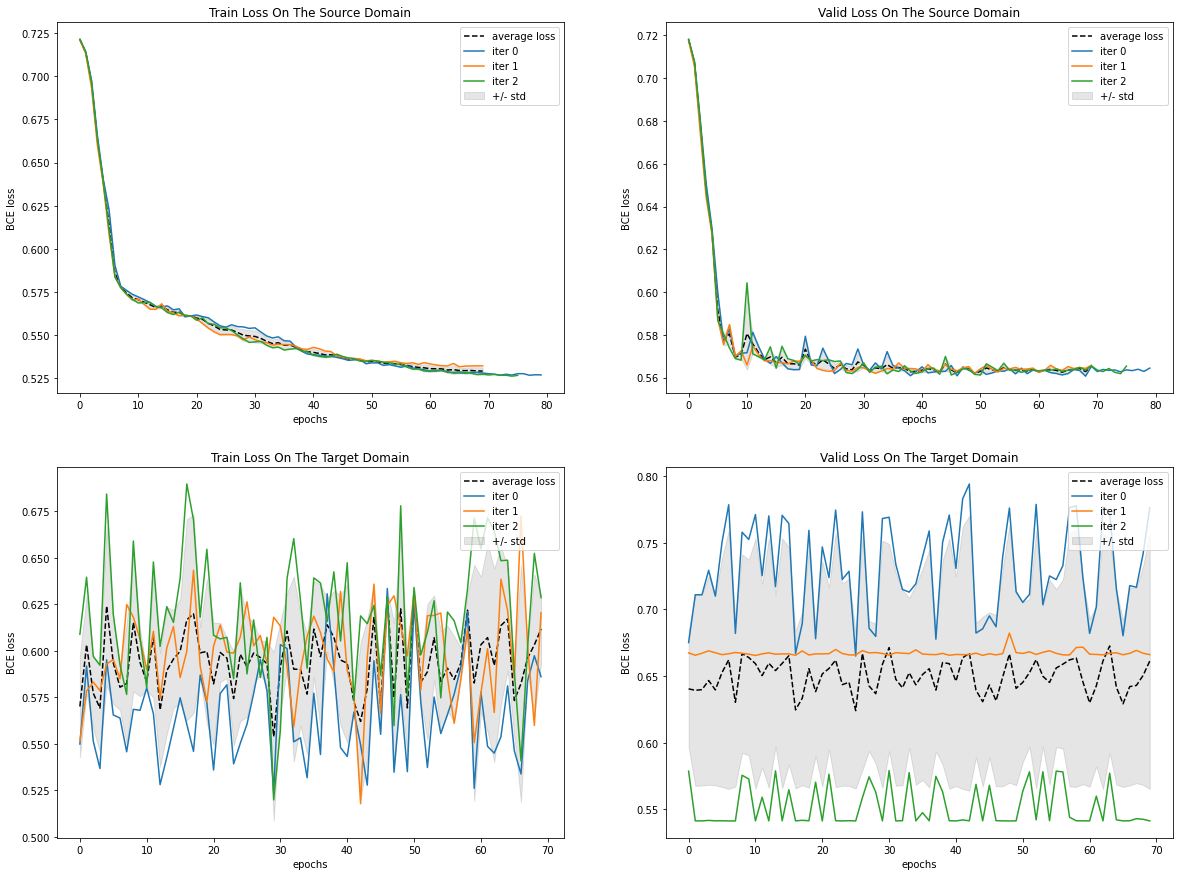

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 50

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 100 MIMIC samples

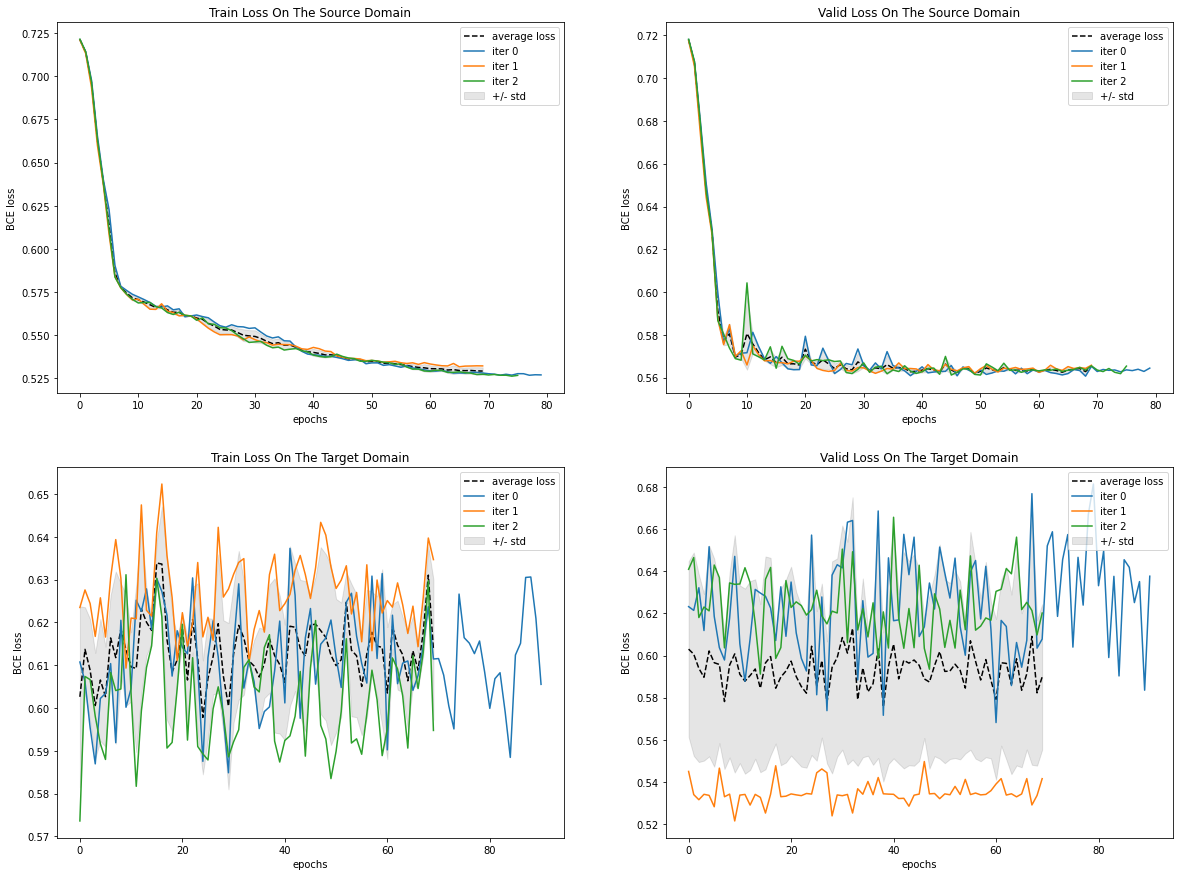

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 100

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 200 MIMIC samples

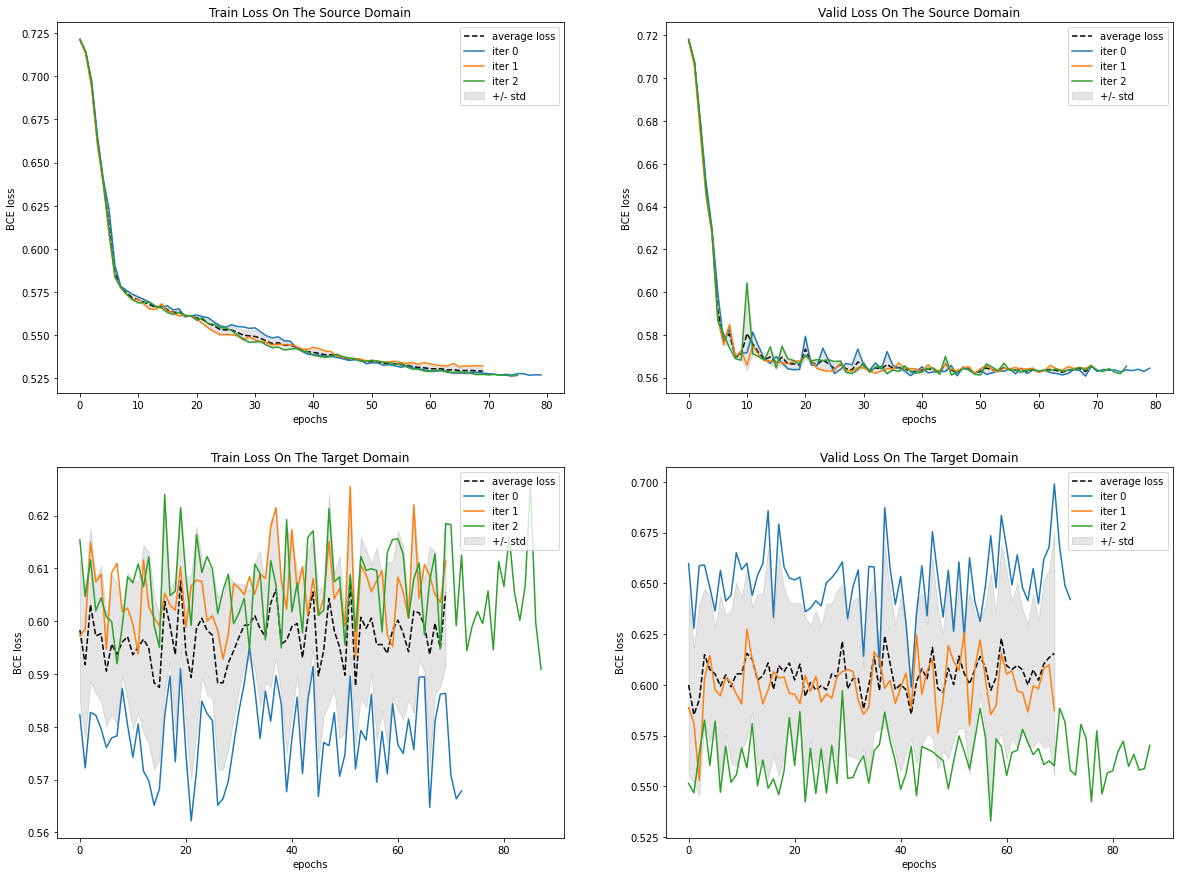

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 200

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 500 MIMIC samples

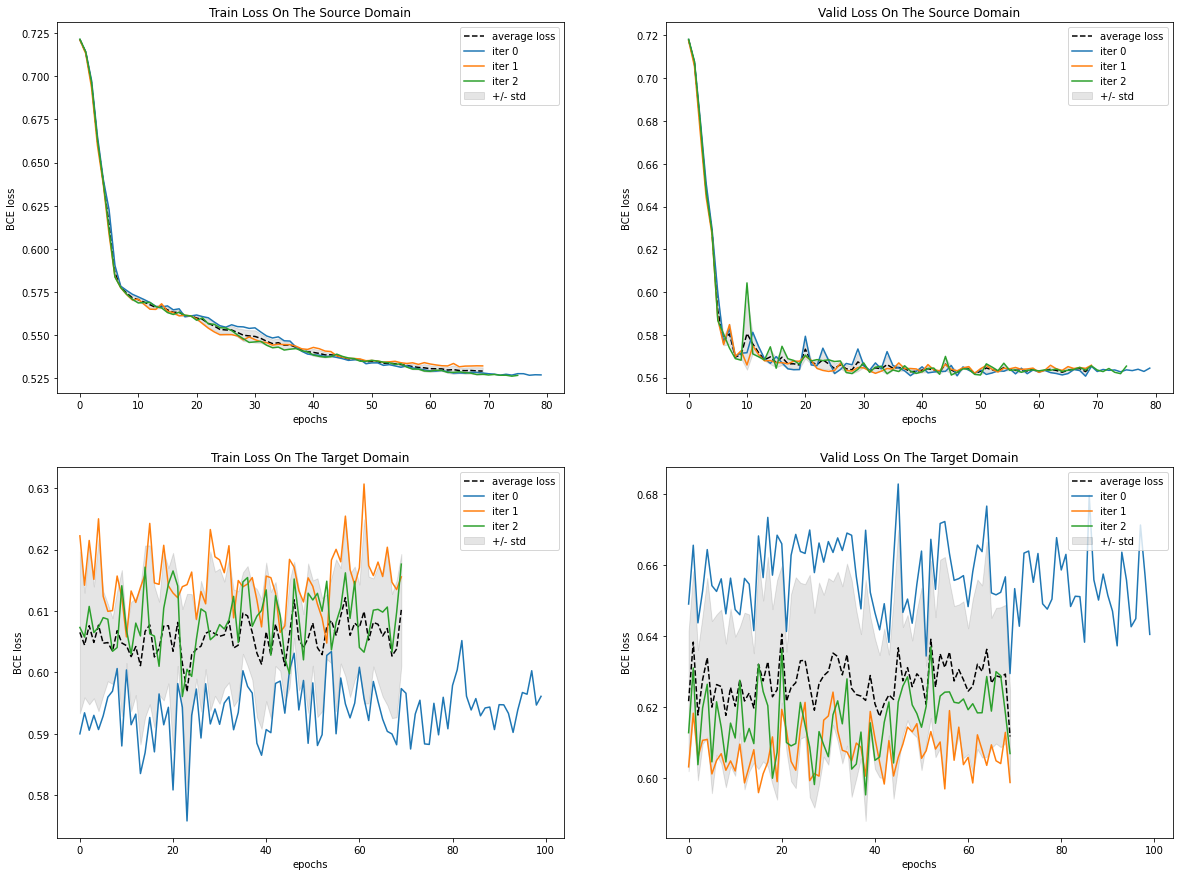

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 500

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 1000 MIMIC samples

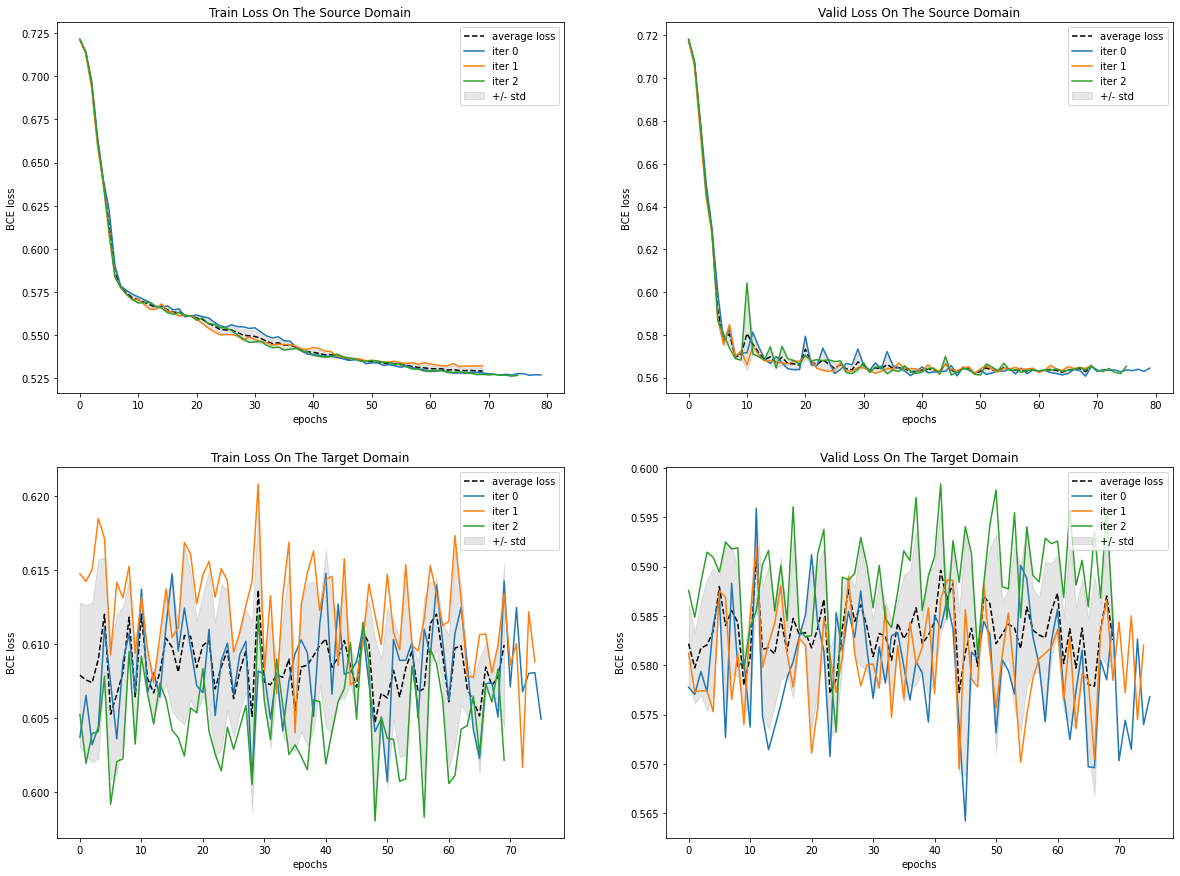

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 1000

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

# Visualize training and validation accuracies for the two training phases

In [19]:
def plot_accuracies(df, phase='target', n_target_samples=20, acc_type='train', ax=None):
   
    if phase == 'target':
        df = df[df['n_target_samples'] == n_target_samples].copy()
    subset_df = df[df['phase'] == phase].copy()
    key = f'{acc_type}_acc'
    max_len = max([len(ele) for ele in subset_df.loc[:, key].values])
    stackable = [np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan) for arr in subset_df.loc[:, key].values]
    acc = np.stack(stackable)

    avg_acc = np.mean(acc, axis=0)
    upper_ = avg_acc + np.std(acc, axis=0)
    lower_ = avg_acc - np.std(acc, axis=0)
    x_ = np.arange(len(upper_))

    ax.fill_between(x_, lower_, upper_, color='k', alpha=0.1)
    ax.plot(avg_acc, 'k--')
    ax.plot(acc.T)
    ax.legend(['average accuracy', 'iter 0', 'iter 1', 'iter 2', '+/- std'], loc='lower right')

    ax.set_title(f'{acc_type} Accuracy on the {phase} domain'.title())
    ax.set_xlabel('epochs')
    ax.set_ylabel('Accuracy')


## 20 MIMIC samples

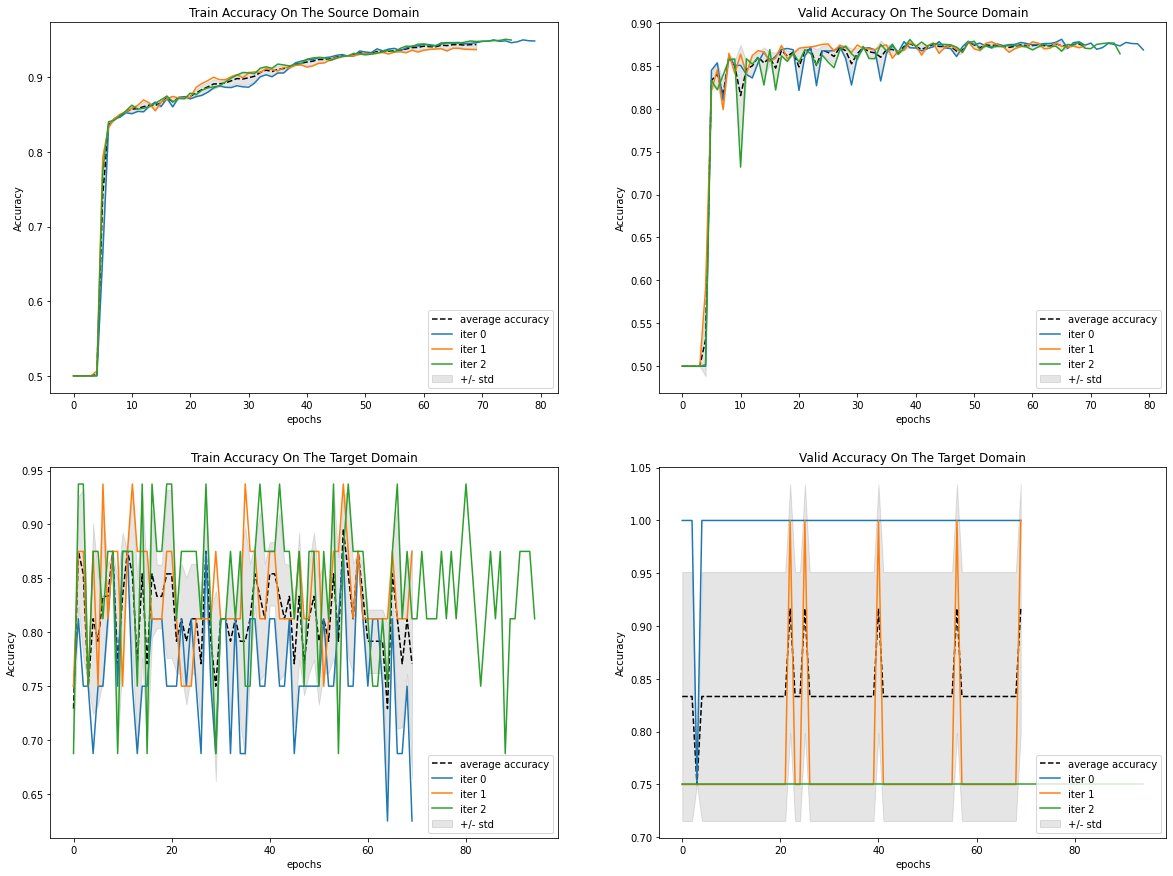

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 20

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 50 MIMIC samples

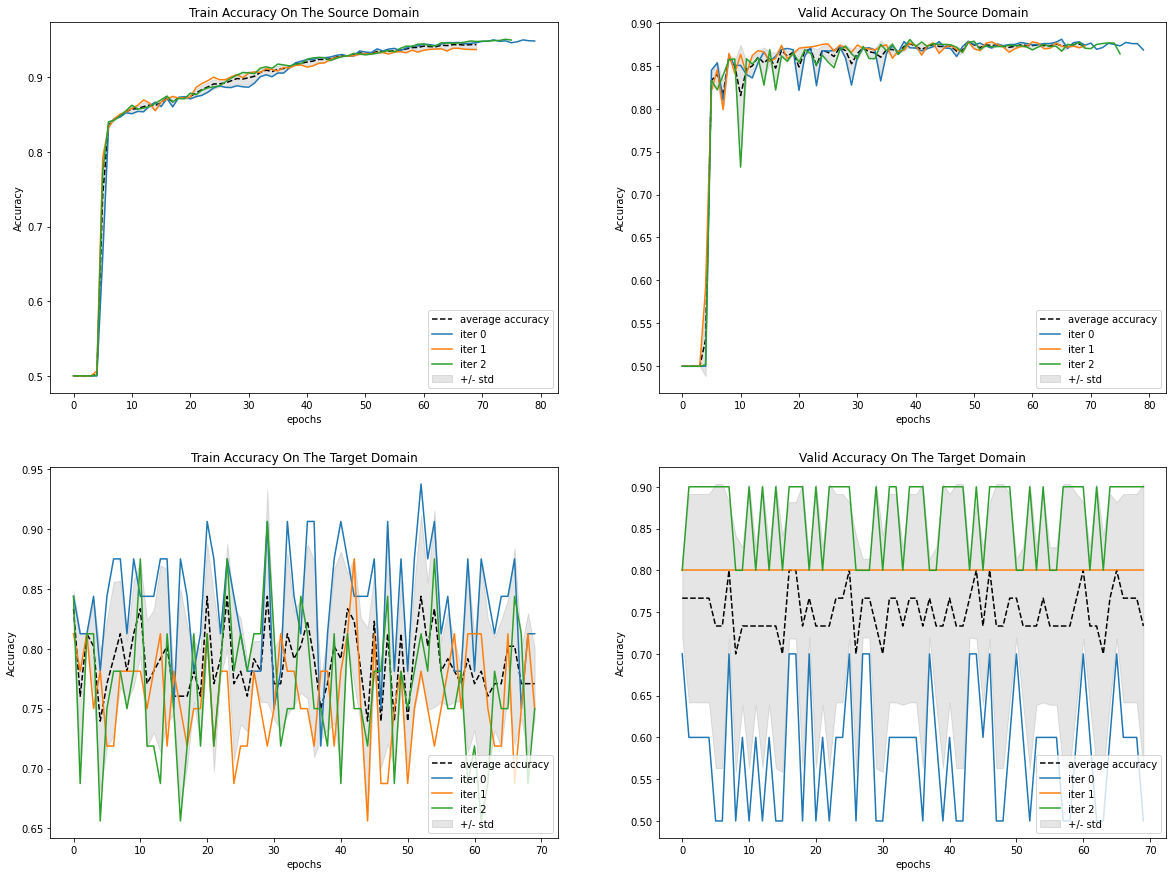

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 50

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 100 MIMIC samples

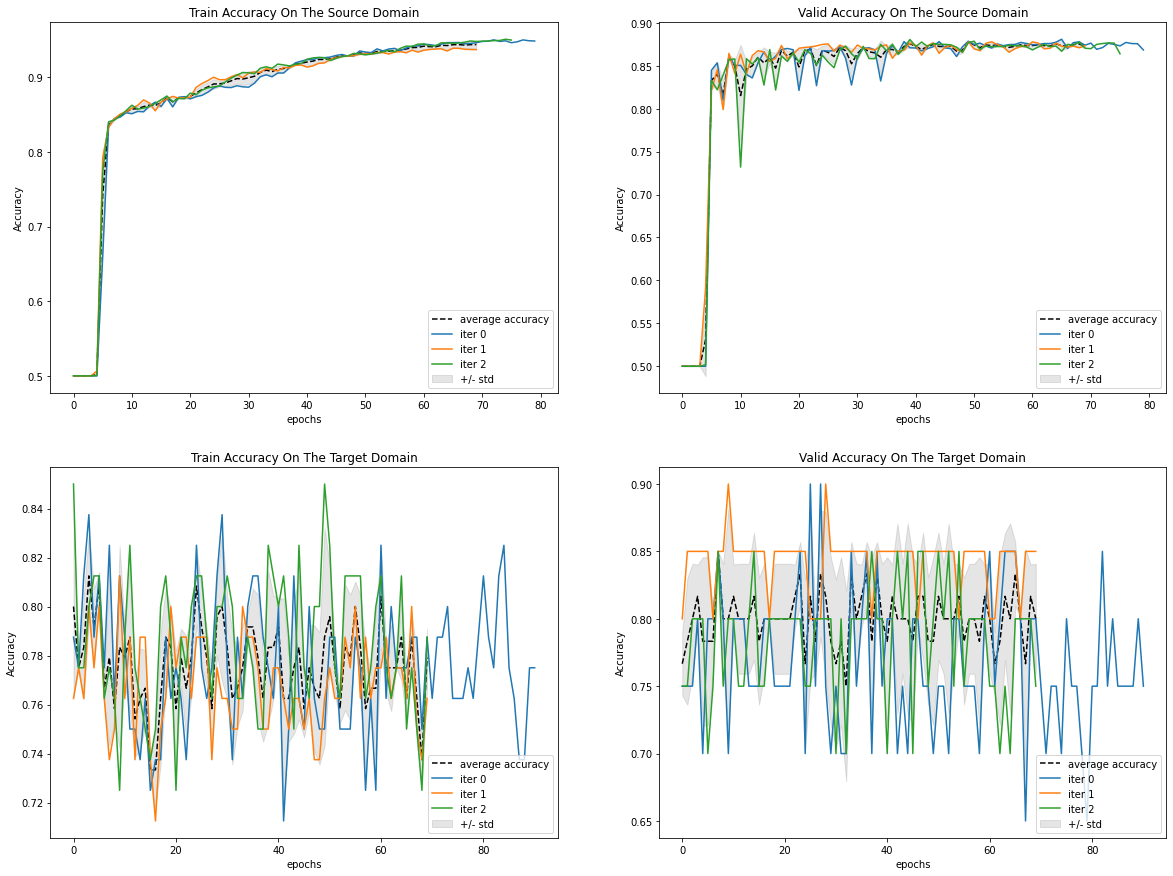

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 100

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 200 MIMIC samples

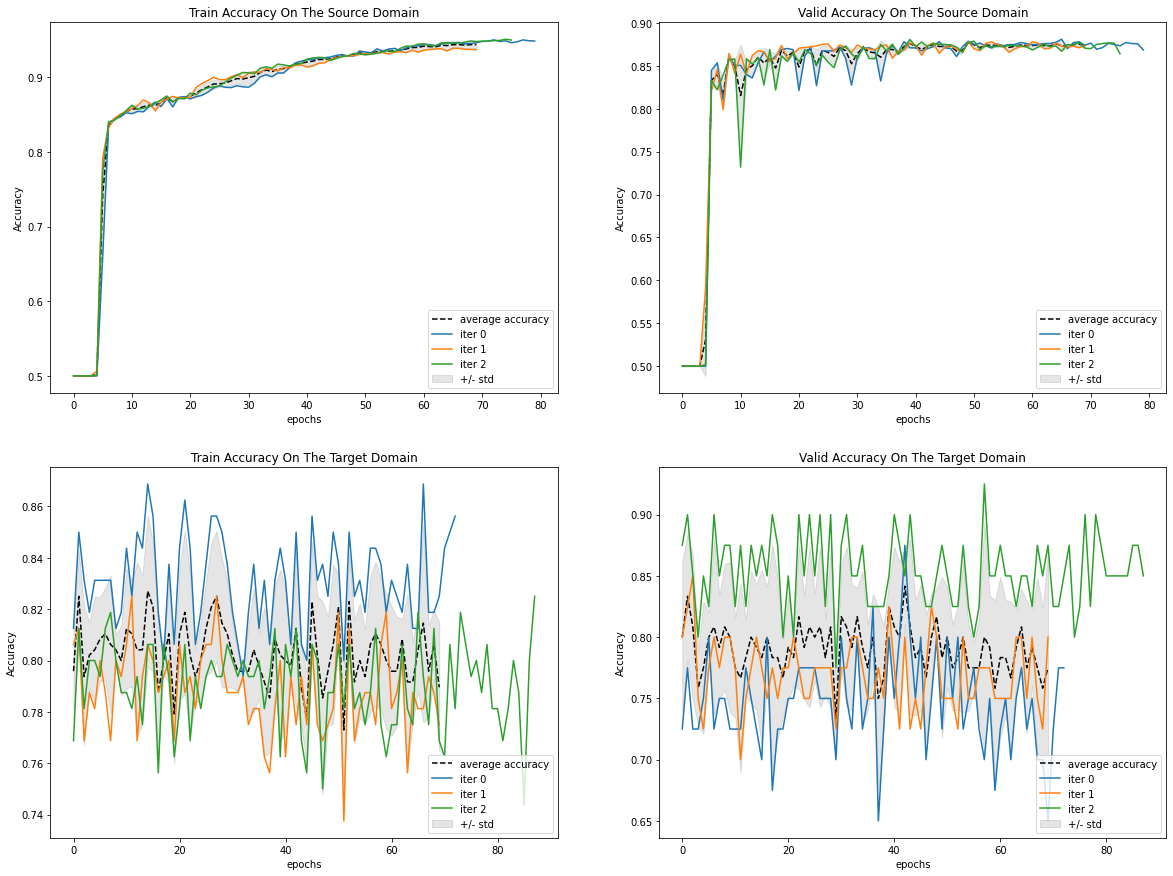

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 200

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 500 MIMIC samples

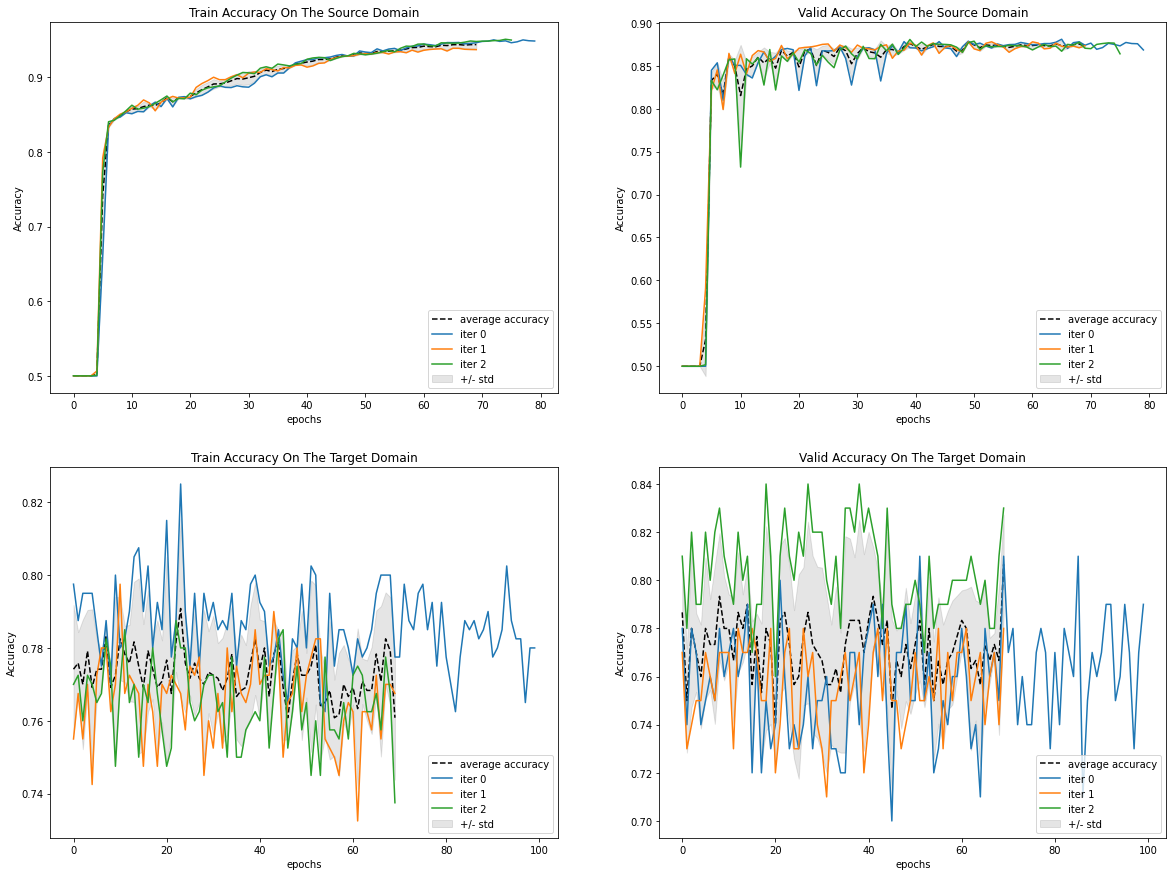

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 500

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 1000 MIMIC samples

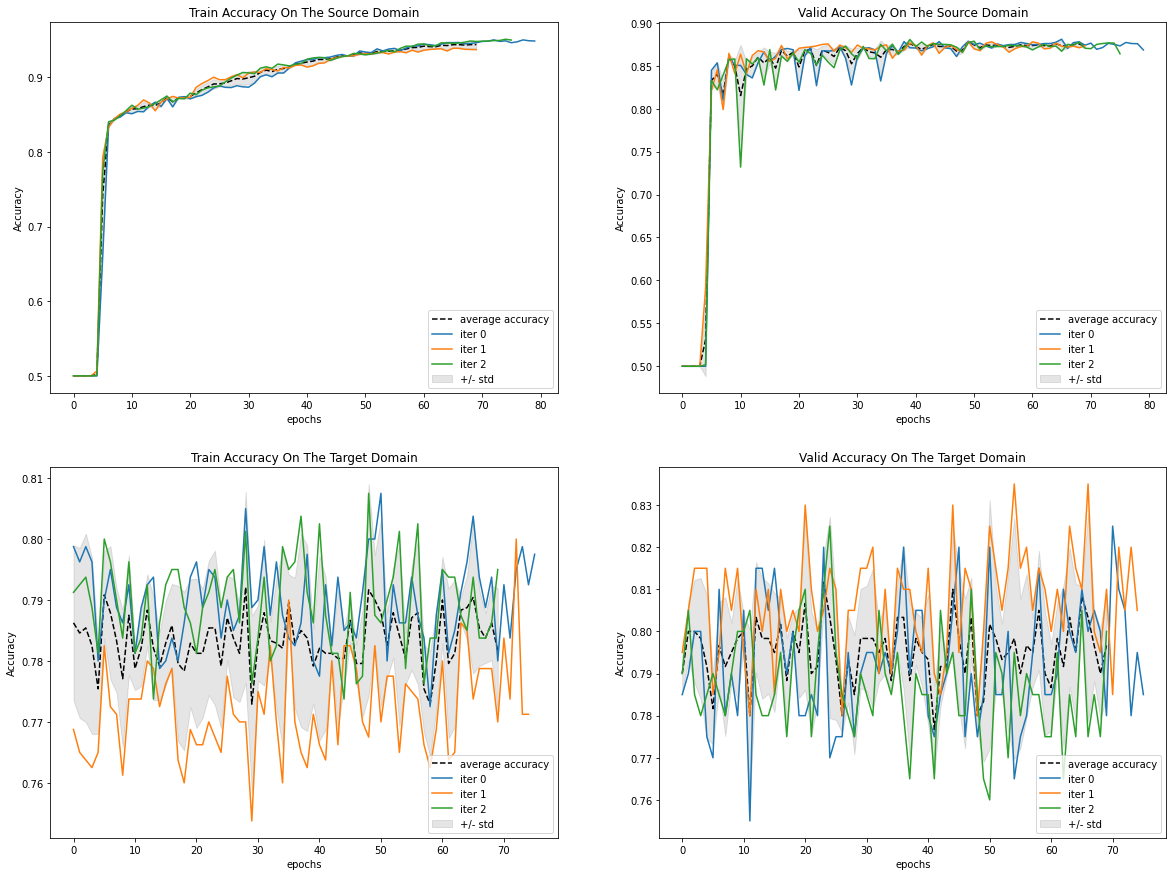

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 1000

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

# Summarize training metrics for trained models

In [26]:
target_meta = model_meta[model_meta['phase'] == 'target']

training_cols = ['final_train_loss', 'final_valid_loss', 'best_valid_loss', 'final_valid_acc', 'best_valid_acc',
                 'mimic_test_acc', 'chexpert_test_acc']

In [27]:
target_meta.groupby('n_target_samples').mean(numeric_only=True)[training_cols]

,final_train_loss,final_valid_loss,best_valid_loss,final_valid_acc,best_valid_acc,mimic_test_acc,chexpert_test_acc
n_target_samples,,,,,,,
20,0.610531,0.526593,0.510409,0.916667,0.916667,0.773043,0.822542
50,0.611756,0.661315,0.623956,0.733333,0.800000,0.773335,0.819417
100,0.611657,0.599798,0.560304,0.783333,0.883333,0.767903,0.800917
200,0.590016,0.599838,0.561517,0.808333,0.883333,0.770452,0.805500
500,0.609756,0.615403,0.606895,0.800000,0.810000,0.769408,0.805583
1000,0.605311,0.581117,0.568958,0.796667,0.828333,0.772416,0.807083
